Housekeeping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Auxiliary functions

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    interaction = 0
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words) == 1:
            interaction = 0
            i_count = 0
        elif len(words)>1 and results_follow==1: # and words[0] not in omit_list
            if len(words)==2 and words[1]=="|":
                var_name = words[0]
                interaction = 1
                i_count = 0
            else:
                if interaction==0:
                    row_names.append(words[0])
                else:
                    row_names.append(var_name+"_"+words[0])                        
                
                if words[2]=='|':
                    t00= t0+1
                    t11 = t1+1
                else:
                    t00 = t0
                    t11 = t1

                buff_v = []
                for w in words[t00:t11]: 
                    w = w.replace(",","")
                    buff_v.append(w)
                table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def read_descriptive_stats(filename,keyword_data,keyword_col,ncols,rownames,start=2,debug=False):
    t0 = start
    t1 = ncols+start
    table_raw = np.empty(t1-t0)
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword_data:
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)))
        elif len(words)>1 and words[0] == keyword_col:
            colnames = words[t0:t1]

    return pd.DataFrame(table_raw[1:,:], columns=colnames, index=rownames)
 
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

Date dictionaries

In [3]:
dates = []
for year in range(1987,2022):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

time_periods_thin = []
for y in range(2006,2022):
    time_periods_thin.append(str(y))
    
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20","t21"]
period_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
    
def rename_interaction(tab,int_subs):
    tab_chunk_1 = tab.iloc[0:7].copy()
    tab_chunk_2 = tab.iloc[7:].copy()
    tab_chunk_1.rename(index=int_subs,inplace=True)
    tab = pd.concat((tab_chunk_1,tab_chunk_2))
    return tab

In [5]:
path = './results/'
ten_dist_moms = read_descriptive_stats(path+'descriptive_stats_tenure_mothers_all.log',
                       keyword_data='hub_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)
ten_dist_nomoms = read_descriptive_stats(path+'descriptive_stats_tenure_mothers_all_0k.log',
                       keyword_data='hub_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)

ten_dist_dads = read_descriptive_stats(path+'descriptive_stats_tenure_fathers_all.log',
                       keyword_data='wife_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)
ten_dist_nodads = read_descriptive_stats(path+'descriptive_stats_tenure_fathers_all_0k.log',
                       keyword_data='wife_ten_y',keyword_col='Variable',ncols=5,
                       rownames=[0,25,50,75],start=2,debug=False)

<a id='index'></a>


# Quantile regressions for tenure: coefficients by year

### Women, 35-45

Jump to
 - [Women 30-35](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
  - [Employment regresssions](#employment)
 
 
 - [Women, extensive margin, 30-35](#women_ext_3035)
 --------------
 Split result tables
 --------------
 Split result tables

In [8]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_3035_hemp_time_int_diff_simple"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_3035_hemp_time_int_diff_simple_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)


In [9]:
tab_moms_45_75

,Coefficient,std,t,p_stat,lower_95,upper_95q75
other_ten_y,0.169700,0.005253,32.31,0.000,0.159405,0.179996
ttrend,0.015127,0.008405,1.80,0.072,-0.001346,0.031600
ttrend2,0.000230,0.000166,1.39,0.164,-0.000094,0.000555
sexo1#c.ttrend_1,0.033960,0.014005,2.42,0.015,0.006510,0.061410
sexo1#c.ttrend2_1,-0.000447,0.000260,-1.72,0.086,-0.000956,0.000063
covid_1,-0.641774,0.305999,-2.10,0.036,-1.241529,-0.042019
covid_2,-0.207204,0.536677,-0.39,0.699,-1.259085,0.844677
1.sexo1,-1.298316,0.175656,-7.39,0.000,-1.642600,-0.954032
covid#sexo1_1,0.204451,0.396097,0.52,0.606,-0.571895,0.980796
covid#sexo1_2,-0.971496,0.592703,-1.64,0.101,-2.133186,0.190194


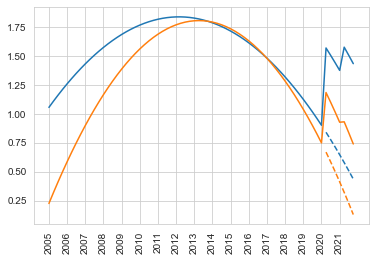

In [13]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid1 = 61  # adjust this for your trend values!!
Tcovid2 = 65  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
date_range = np.arange(2005,2022)

average_partner_tenure_for_this_quantile = (ten_dist_moms['p25'][25]+ten_dist_dads['p25'][25])/2

predict_dads = tab_moms_45_25[clab]['_cons']+tab_moms_45_25[clab]['ttrend']*t_range+ \
                tab_moms_45_25[clab]['ttrend2']*t_range**2 + \
                tab_moms_45_25[clab]['other_ten_y']*average_partner_tenure_for_this_quantile
predict_moms = predict_dads + tab_moms_45_25[clab]['sexo1#c.ttrend_1']*t_range+ \
                tab_moms_45_25[clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                tab_moms_45_25[clab]['1.sexo1']
predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + tab_moms_45_25[clab]['covid_1']
predict_dads_covid2 = predict_dads[Tcovid2:] + tab_moms_45_25[clab]['covid_2']
predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + tab_moms_45_25[clab]['covid_1']+\
                                                        tab_moms_45_25[clab]['covid#sexo1_1']
predict_moms_covid2 = predict_moms[Tcovid2:] + tab_moms_45_25[clab]['covid_2']+\
                                                        tab_moms_45_25[clab]['covid#sexo1_2']
predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))

plt.plot(t_range, np.hstack((predict_dads[:Tcovid1],predict_dads_covid)))
# plt.plot(t_range[Tcovid:], predict_dads_covid,c=colors[0])
plt.plot(t_range[Tcovid1:], predict_dads[Tcovid1:],ls='--',c=colors[0])
plt.plot(t_range, np.hstack((predict_moms[:Tcovid1],predict_moms_covid)))
plt.plot(t_range[Tcovid1:], predict_moms[Tcovid1:],ls='--',c=colors[1])
plt.xticks(t_range[::4],date_range,rotation=90)
plt.show()

In [11]:
predict_moms_covid, predict_moms[-6:]

(array([1.18372664, 1.10115774, 1.01569084, 0.92732594, 0.93089314,
        0.83673224, 0.73967334]),
 array([0.58675144, 0.50128454, 0.41291964, 0.32165674, 0.22749584,
        0.13043694]))

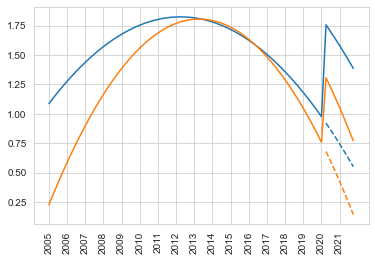

In [77]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()

date_range = np.arange(2005,2022)

average_partner_tenure_for_this_quantile = (ten_dist_moms['p25'][25]+ten_dist_dads['p25'][25])/2

predict_dads = tab_moms_45_25['Coefficient']['_cons']+tab_moms_45_25['Coefficient']['ttrend']*t_range+ \
                tab_moms_45_25['Coefficient']['ttrend2']*t_range**2 + \
                tab_moms_45_25['Coefficient']['other_ten_y']*average_partner_tenure_for_this_quantile
predict_moms = predict_dads + tab_moms_45_25['Coefficient']['sexo1#c.ttrend_1']*t_range+ \
                tab_moms_45_25['Coefficient']['sexo1#c.ttrend2_1']*t_range**2 + \
                tab_moms_45_25['Coefficient']['1.sexo1']
predict_dads_covid = predict_dads[Tcovid:] + tab_moms_45_25['Coefficient']['1.covid']
predict_moms_covid = predict_moms[Tcovid:] + tab_moms_45_25['Coefficient']['1.covid']+ \
                    tab_moms_45_25['Coefficient']['covid#sexo1_1']

plt.plot(t_range, np.hstack((predict_dads[:Tcovid],predict_dads_covid)))
# plt.plot(t_range[Tcovid:], predict_dads_covid,c=colors[0])
plt.plot(t_range[Tcovid:], predict_dads[Tcovid:],ls='--',c=colors[0])
plt.plot(t_range, np.hstack((predict_moms[:Tcovid],predict_moms_covid)))
plt.plot(t_range[Tcovid:], predict_moms[Tcovid:],ls='--',c=colors[1])
plt.xticks(t_range[::4],date_range,rotation=90)
plt.show()

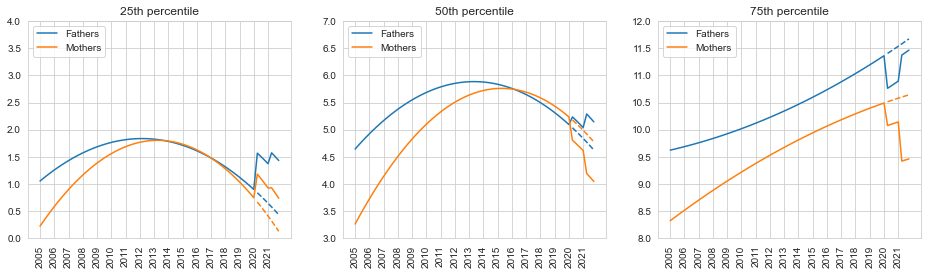

In [14]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   

    av_partner_tenure_for_this_quant = (ten_dist_moms['p{}'.format(q)][q]+ten_dist_dads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    
    predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_dads_covid2 = predict_dads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

    predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_moms_covid2 = predict_moms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range, np.hstack((predict_dads[:Tcovid],predict_dads_covid)),label='Fathers')
    plt.plot(t_range[Tcovid:], predict_dads[Tcovid:],ls='--',c=colors[0])
    plt.plot(t_range, np.hstack((predict_moms[:Tcovid],predict_moms_covid)),label='Mothers')
    plt.plot(t_range[Tcovid:], predict_moms[Tcovid:],ls='--',c=colors[1])
    plt.legend(loc=2)
#     plt.axvline(Tcovid,c='r',lw=0.5)
    plt.ylim(ylims[iq])
    plt.xticks(t_range[::4],date_range,rotation=90)
plt.show()

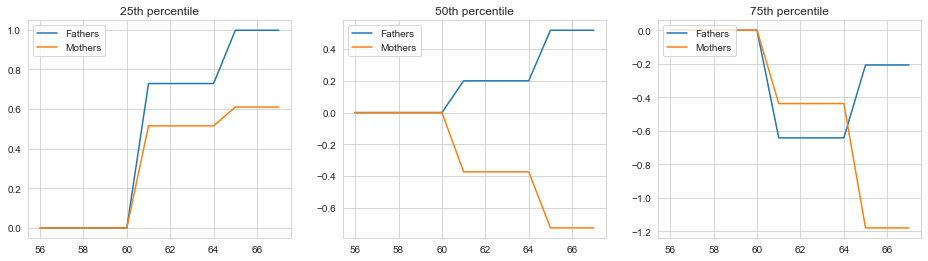

In [15]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):  
    
    av_partner_tenure_for_this_quant = (ten_dist_moms['p{}'.format(q)][q]+ten_dist_dads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_dads_covid2 = predict_dads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

    predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_moms_covid2 = predict_moms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))

    trend_devs_dads = np.hstack((predict_dads[:Tcovid],predict_dads_covid)) - predict_dads
    trend_devs_moms = np.hstack((predict_moms[:Tcovid],predict_moms_covid)) - predict_moms
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range[-12:],trend_devs_dads[-12:],label='Fathers')
    plt.plot(t_range[-12:],trend_devs_moms[-12:],label='Mothers')
    plt.legend(loc=2)
#     plt.axvline(Tcovid,c='r',lw=0.5)
#     plt.ylim(ylims[iq])
#     plt.xticks(t_range[-6::4],date_range,rotation=90)
plt.show()

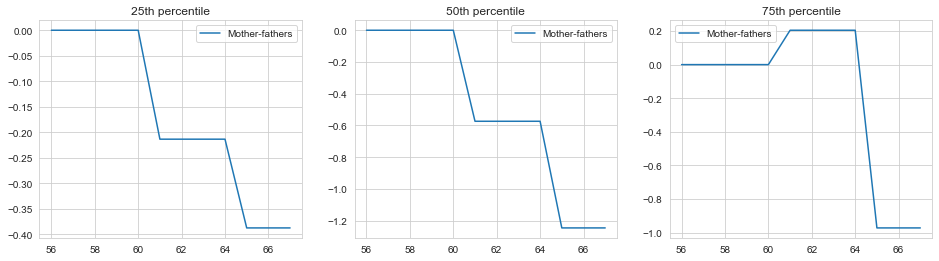

In [138]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

DiD_children = {}

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):  
    
    av_partner_tenure_for_this_quant = (ten_dist_moms['p{}'.format(q)][q]+ten_dist_dads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_dads_covid2 = predict_dads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

    predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_moms_covid2 = predict_moms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))

    trend_devs_dads = np.hstack((predict_dads[:Tcovid],predict_dads_covid)) - predict_dads
    trend_devs_moms = np.hstack((predict_moms[:Tcovid],predict_moms_covid)) - predict_moms
    
    DiD_children[q] = trend_devs_moms-trend_devs_dads
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range[-12:],trend_devs_moms[-12:]-trend_devs_dads[-12:],label='Mother-fathers')
    plt.legend(loc='best')
#     plt.axvline(Tcovid,c='r',lw=0.5)
#     plt.ylim(ylims[iq])
#     plt.xticks(t_range[-6::4],date_range,rotation=90)
plt.show()

No children

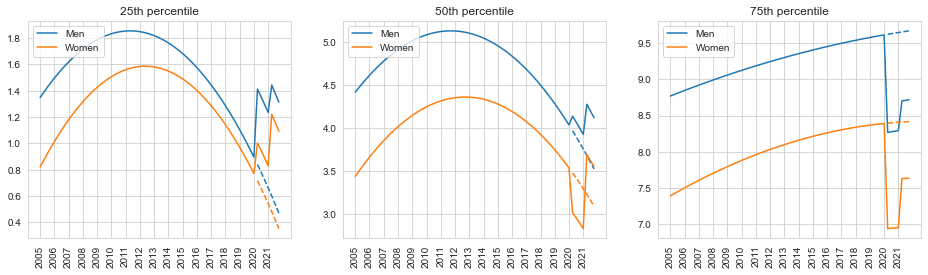

In [130]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   

    av_partner_tenure_for_this_quant = (ten_dist_nomoms['p{}'.format(q)][q]+ten_dist_nodads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    
    predict_dads_covid1 = predict_dads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_dads_covid2 = predict_dads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_dads_covid = np.hstack((predict_dads_covid1,predict_dads_covid2))

    predict_moms_covid1 = predict_moms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_moms_covid2 = predict_moms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_moms_covid = np.hstack((predict_moms_covid1,predict_moms_covid2))
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range, np.hstack((predict_dads[:Tcovid],predict_dads_covid)),label='Men')
    plt.plot(t_range[Tcovid:], predict_dads[Tcovid:],ls='--',c=colors[0])
    plt.plot(t_range, np.hstack((predict_moms[:Tcovid],predict_moms_covid)),label='Women')
    plt.plot(t_range[Tcovid:], predict_moms[Tcovid:],ls='--',c=colors[1])
    plt.legend(loc=2)
#     plt.axvline(Tcovid,c='r',lw=0.5)
#     plt.ylim(ylims[iq])
    plt.xticks(t_range[::4],date_range,rotation=90)
plt.show()

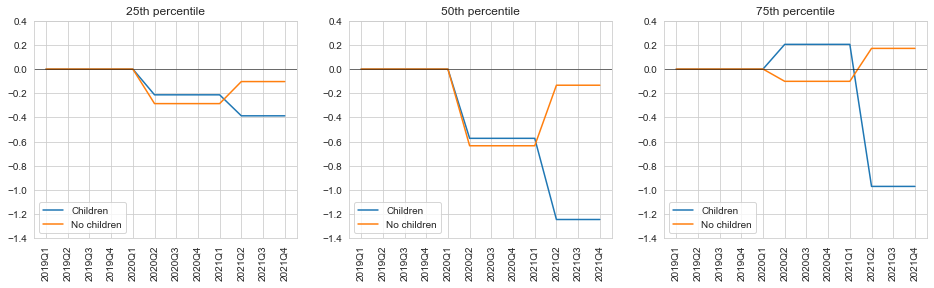

In [147]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):  
    
    av_partner_tenure_for_this_quant = (ten_dist_nomoms['p{}'.format(q)][q]+ten_dist_nodads['p{}'.format(q)][q])/2

    predict_nodads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_nomoms = predict_nodads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    predict_nodads_covid1 = predict_nodads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_nodads_covid2 = predict_nodads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_nodads_covid = np.hstack((predict_nodads_covid1,predict_nodads_covid2))

    predict_nomoms_covid1 = predict_nomoms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_nomoms_covid2 = predict_nomoms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_nomoms_covid = np.hstack((predict_nomoms_covid1,predict_nomoms_covid2))

    trend_devs_nodads = np.hstack((predict_nodads[:Tcovid],predict_nodads_covid)) - predict_nodads
    trend_devs_nomoms = np.hstack((predict_nomoms[:Tcovid],predict_nomoms_covid)) - predict_nomoms
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range[-12:],DiD_children[q][-12:],label='Children')
    plt.plot(t_range[-12:],trend_devs_nomoms[-12:]-trend_devs_nodads[-12:],label='No children')
    plt.legend(loc=3)
    plt.axhline(0,c='k',lw=0.5)
    plt.ylim(-1.4,0.4)
    plt.xticks(t_range[-12:],dates[-12:],rotation=90)
plt.show()

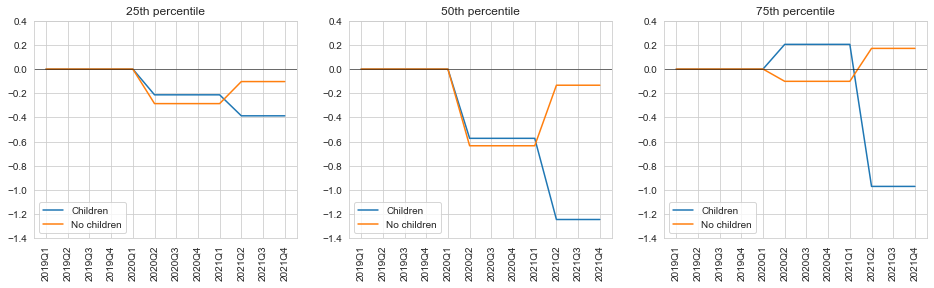

In [147]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
clab = 'Coefficient'
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):  
    
    av_partner_tenure_for_this_quant = (ten_dist_nomoms['p{}'.format(q)][q]+ten_dist_nodads['p{}'.format(q)][q])/2

    predict_nodads = all_tabs[q][clab]['_cons']+all_tabs[q][clab]['ttrend']*t_range+ \
                    all_tabs[q][clab]['ttrend2']*t_range**2 + \
                    all_tabs[q][clab]['other_ten_y']*av_partner_tenure_for_this_quant
    predict_nomoms = predict_nodads + all_tabs[q][clab]['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q][clab]['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q][clab]['1.sexo1']
    predict_nodads_covid1 = predict_nodads[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']
    predict_nodads_covid2 = predict_nodads[Tcovid2:] + all_tabs[q][clab]['covid_2']
    predict_nodads_covid = np.hstack((predict_nodads_covid1,predict_nodads_covid2))

    predict_nomoms_covid1 = predict_nomoms[Tcovid1:Tcovid2] + all_tabs[q][clab]['covid_1']+\
                                                            all_tabs[q][clab]['covid#sexo1_1']
    predict_nomoms_covid2 = predict_nomoms[Tcovid2:] + all_tabs[q][clab]['covid_2']+\
                                                            all_tabs[q][clab]['covid#sexo1_2']
    predict_nomoms_covid = np.hstack((predict_nomoms_covid1,predict_nomoms_covid2))

    trend_devs_nodads = np.hstack((predict_nodads[:Tcovid],predict_nodads_covid)) - predict_nodads
    trend_devs_nomoms = np.hstack((predict_nomoms[:Tcovid],predict_nomoms_covid)) - predict_nomoms
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range[-12:],DiD_children[q][-12:],label='Children')
    plt.plot(t_range[-12:],trend_devs_nomoms[-12:]-trend_devs_nodads[-12:],label='No children')
    plt.legend(loc=3)
    plt.axhline(0,c='k',lw=0.5)
    plt.ylim(-1.4,0.4)
    plt.xticks(t_range[-12:],dates[-12:],rotation=90)
plt.show()

## Just plot the dammed coefficients

In [149]:
tab_moms_45_25

,Coefficient,std,t,p_stat,lower_95,upper_95q25
other_ten_y,0.103145,0.003079,33.50,0.000,0.097109,0.109180
ttrend,0.054563,0.006062,9.00,0.000,0.042683,0.066443
ttrend2,-0.000952,0.000107,-8.94,0.000,-0.001161,-0.000743
sexo1#c.ttrend_1,0.041095,0.008721,4.71,0.000,0.024002,0.058188
sexo1#c.ttrend2_1,-0.000497,0.000150,-3.32,0.001,-0.000790,-0.000203
covid_1,0.727755,0.132293,5.50,0.000,0.468462,0.987048
covid_2,0.996369,0.234292,4.25,0.000,0.537160,1.455578
1.sexo1,-0.829443,0.086997,-9.53,0.000,-0.999955,-0.658931
covid#sexo1_1,-0.213349,0.188784,-1.13,0.258,-0.583364,0.156666
covid#sexo1_2,-0.387133,0.260800,-1.48,0.138,-0.898298,0.124032


In [17]:
coeffs_period_children = {}
coeffs_period_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2']) 


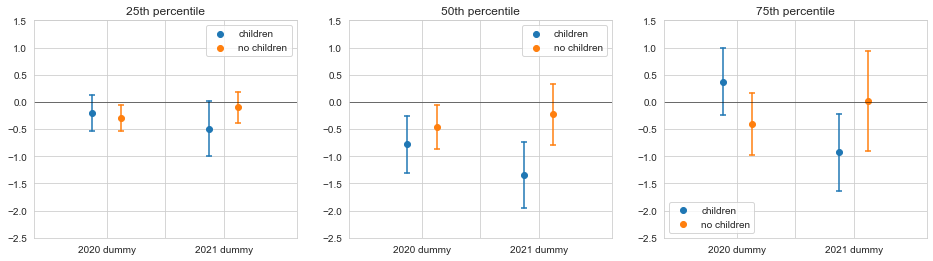

In [24]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,2),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,2),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,2),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,2.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,2.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,2.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(2):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-2.5,1.5)
    plt.xlim(-0.5,1.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125],['2020 dummy','','2021 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/coeffs_compare_simple.pdf',format='pdf',bbox_inches='tight')
plt.show()

## With controls

In [19]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_3035_hemp_time_int_diff"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_3035_hemp_time_int_diff_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_45_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)


In [223]:
tab_moms_45_25

,Coefficient,std,t,p_stat,lower_95,upper_95q25
other_ten_y,0.080217,0.003413,23.50,0.000,0.073527,0.086907
ttrend,0.044030,0.006718,6.55,0.000,0.030864,0.057197
ttrend2,-0.000751,0.000106,-7.12,0.000,-0.000957,-0.000544
sexo1#c.ttrend_1,0.034543,0.007783,4.44,0.000,0.019289,0.049797
sexo1#c.ttrend2_1,-0.000443,0.000116,-3.81,0.000,-0.000670,-0.000215
covid_1,0.546773,0.141722,3.86,0.000,0.268999,0.824546
covid_2,0.937799,0.228697,4.10,0.000,0.489555,1.386042
1.sexo1,-0.630380,0.092123,-6.84,0.000,-0.810940,-0.449819
covid#sexo1_1,-0.210845,0.169524,-1.24,0.214,-0.543111,0.121421
covid#sexo1_2,-0.490860,0.260105,-1.89,0.059,-1.000662,0.018942


In [20]:
coeffs_children = {}
coeffs_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2']) 


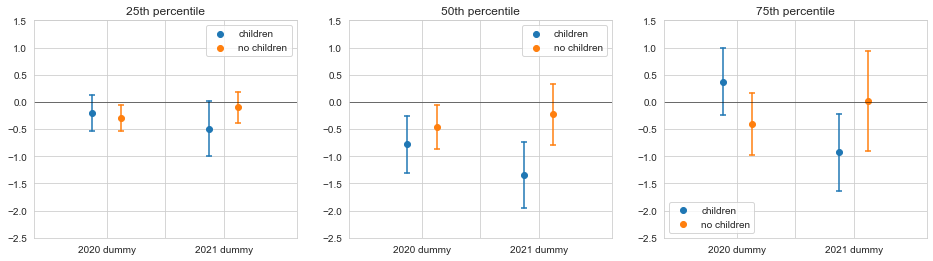

In [23]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,2),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,2),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,2),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,2.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,2.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,2.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(2):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
#     plt.legend(loc=2)
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-2.5,1.5)
    plt.xlim(-0.5,1.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125],['2020 dummy','','2021 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/coeffs_compare_controls.pdf',format='pdf',bbox_inches='tight')
plt.show()

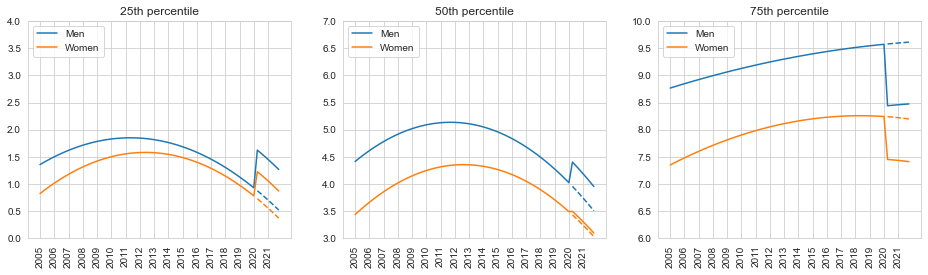

In [101]:
t_range = np.arange(0,68) # adjust this for your trend values!!
T = t_range.size
Tcovid = 61  # adjust this for your trend values!!
colors = sn.color_palette()
ylims = ((0,4),(3,7),(6,10))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   

    av_partner_tenure_for_this_quant = (ten_dist_nomoms['p{}'.format(q)][q]+ten_dist_nodads['p{}'.format(q)][q])/2

    predict_dads = all_tabs[q]['Coefficient']['_cons']+all_tabs[q]['Coefficient']['ttrend']*t_range+ \
                    all_tabs[q]['Coefficient']['ttrend2']*t_range**2 + \
                    all_tabs[q]['Coefficient']['other_ten_y']*av_partner_tenure_for_this_quant
    predict_moms = predict_dads + all_tabs[q]['Coefficient']['sexo1#c.ttrend_1']*t_range+ \
                    all_tabs[q]['Coefficient']['sexo1#c.ttrend2_1']*t_range**2 + \
                    all_tabs[q]['Coefficient']['1.sexo1']
    predict_dads_covid = predict_dads[Tcovid:] + all_tabs[q]['Coefficient']['1.covid']
    predict_moms_covid = predict_moms[Tcovid:] + all_tabs[q]['Coefficient']['1.covid']+ \
                        all_tabs[q]['Coefficient']['covid#sexo1_1']
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.plot(t_range, np.hstack((predict_dads[:Tcovid],predict_dads_covid)),label='Men')
    plt.plot(t_range[Tcovid:], predict_dads[Tcovid:],ls='--',c=colors[0])
    plt.plot(t_range, np.hstack((predict_moms[:Tcovid],predict_moms_covid)),label='Women')
    plt.plot(t_range[Tcovid:], predict_moms[Tcovid:],ls='--',c=colors[1])
    plt.xticks(t_range[::4],date_range,rotation=90)
    plt.legend(loc=2)
    plt.ylim(ylims[iq])
plt.show()

In [6]:
coeffs_period = {}
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))
for level in ['p25','p50','p75',"Mean"]:
    coeffs_period[level] = {}
    for q in [25,50,75]:
        coeffs = np.zeros(0)
        ten = ten_dist_moms[level][q]
        for period in time_periods:
            coef_b0 = all_tabs[q]['Coefficient'][period]
            coef_b1 = all_tabs[q]['Coefficient'][int_subs[period]]
            coeffs = np.hstack((coeffs,coef_b0+coef_b1*ten))    
        coeffs_period[level][q] = coeffs.copy()

coeffs_period_0k = {}
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))
for level in ['p25','p50','p75',"Mean"]:
    coeffs_period_0k[level] = {}
    for q in [25,50,75]:
        coeffs = np.zeros(0)
        ten = ten_dist_nomoms[level][q]
        for period in time_periods:
            coef_b0 = all_tabs_0k[q]['Coefficient'][period]
            coef_b1 = all_tabs_0k[q]['Coefficient'][int_subs[period]]
            coeffs = np.hstack((coeffs,coef_b0+coef_b1*ten))    
        coeffs_period_0k[level][q] = coeffs.copy()

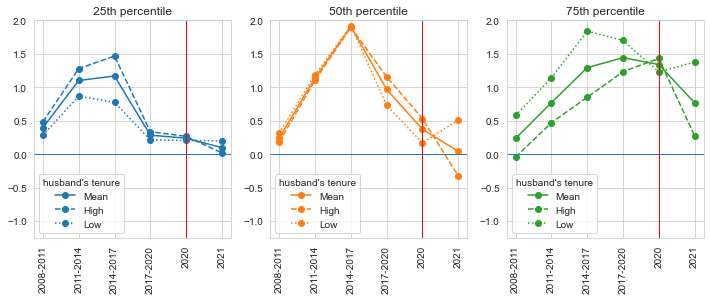

In [128]:
T = len(time_periods)
# time_periods_thin_labels= time_periods_thin
colors = sn.color_palette()

plt.figure(figsize=(12,4))
# plt.suptitle('Predicted time effect in quantile regressions, women 30-35 with kids, Spain',fontsize=14,y=1.05)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{}th percentile'.format(q),fontsize=12)
    plt.plot(np.arange(0,T*2,2),coeffs_period['Mean'][q],marker='o', label='Mean'.format(q),color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period['p75'][q],marker='o', label='High'.format(q),color=colors[j],ls='--')
    plt.plot(np.arange(0,T*2,2),coeffs_period['p25'][q],marker='o', label='Low'.format(q),color=colors[j],ls=':')
#     plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
#     plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
#     for i in range(T):
#         plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),period_labels,rotation=90)
    plt.legend(title="husband's tenure")
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.25,2)

plt.savefig('./plots_tenure/qregs_spa_3035_time_intaction_women_kids.pdf',format='pdf',bbox_inches='tight')
plt.show()

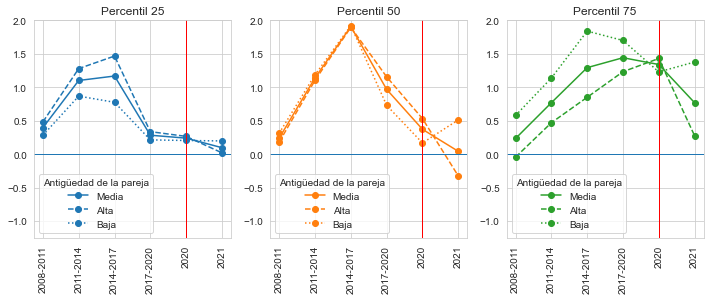

In [10]:
T = len(time_periods)
# time_periods_thin_labels= time_periods_thin
colors = sn.color_palette()

plt.figure(figsize=(12,4))
# plt.suptitle('Predicted time effect in quantile regressions, women 30-35 with kids, Spain',fontsize=14,y=1.05)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('Percentil {}'.format(q),fontsize=12)
    plt.plot(np.arange(0,T*2,2),coeffs_period['Mean'][q],marker='o', label='Media'.format(q),color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period['p75'][q],marker='o', label='Alta'.format(q),color=colors[j],ls='--')
    plt.plot(np.arange(0,T*2,2),coeffs_period['p25'][q],marker='o', label='Baja'.format(q),color=colors[j],ls=':')
#     plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
#     plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
#     for i in range(T):
#         plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),period_labels,rotation=90)
    plt.legend(title="Antigüedad de la pareja")
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.25,2)

plt.savefig('./plots_tenure/qregs_spa_3035_time_intaction_women_kids.png',format='png',bbox_inches='tight')
plt.show()

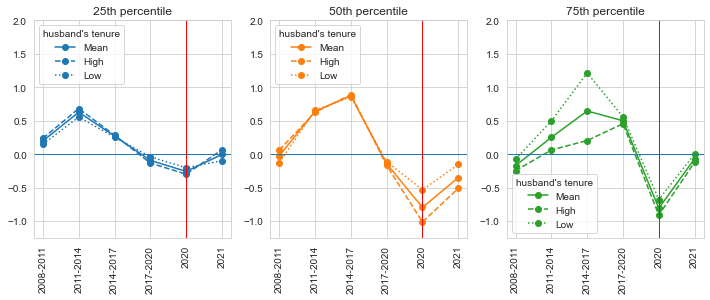

In [127]:
T = len(time_periods)
# time_periods_thin_labels= time_periods_thin
colors = sn.color_palette()

plt.figure(figsize=(12,4))
# plt.suptitle('Predicted time effect in quantile regressions, women 30-35 with kids, Spain',fontsize=14,y=1.05)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{}th percentile'.format(q),fontsize=12)
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k['Mean'][q],marker='o', label='Mean'.format(q),color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k['p75'][q],marker='o', label='High'.format(q),color=colors[j],ls='--')
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k['p25'][q],marker='o', label='Low'.format(q),color=colors[j],ls=':')
#     plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
#     plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
#     for i in range(T):
#         plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),period_labels,rotation=90)
    plt.legend(title="husband's tenure")
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.25,2)

plt.savefig('./plots_tenure/qregs_spa_3035_time_intaction_women_0k.pdf',format='pdf',bbox_inches='tight')
plt.show()

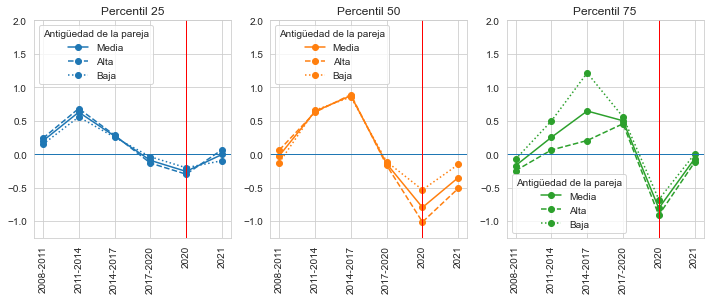

In [8]:
T = len(time_periods)
# time_periods_thin_labels= time_periods_thin
colors = sn.color_palette()

plt.figure(figsize=(12,4))
# plt.suptitle('Predicted time effect in quantile regressions, women 30-35 with kids, Spain',fontsize=14,y=1.05)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('Percentil {}'.format(q),fontsize=12)
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k['Mean'][q],marker='o', label='Media'.format(q),color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k['p75'][q],marker='o', label='Alta'.format(q),color=colors[j],ls='--')
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k['p25'][q],marker='o', label='Baja'.format(q),color=colors[j],ls=':')
#     plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
#     plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
#     for i in range(T):
#         plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),period_labels,rotation=90)
    plt.legend(title="Antigüedad de la pareja")
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.25,2)

plt.savefig('./plots_tenure/qregs_spa_3035_time_intaction_women_0k.png',format='png',bbox_inches='tight')
plt.show()

<a id='urgh_3035'></a>


## Quantile regressions for tenure: coefficients by year

### Men 30-35

Jump to
 - [Women <45](#index)
 - [Women 30-35](#women_3035)
 - [Men <45](#urgh)
 
 
   - [Employment regresssions](#employment)
 
 
 - [Women, extensive margin, 30-35](#women_ext_3035)
 - [Men, extensive margin, 30-35](#men_ext_3035)
 --------------
 Split result tables

In [7]:
path = './results/'
omits = ['period_y','period_y#c.wife_ten_y']
int_subs ={}
for t in time_periods:
    int_subs[t] = 'ten_'+t[1:]

file_split('sqtreg_fathers_3035_hemp_time_int.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25 = rename_interaction(read_table(path+'sqtreg_fathers_3035_hemp_time_int_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False),int_subs)
tab_dads_45_50 = rename_interaction(read_table(path+'sqtreg_fathers_3035_hemp_time_int_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False),int_subs)
tab_dads_45_75 = rename_interaction(read_table(path+'sqtreg_fathers_3035_hemp_time_int_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False),int_subs)

file_split('sqtreg_fathers_3035_hemp_time_int_0k.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25_0k = rename_interaction(read_table(path+'sqtreg_fathers_3035_hemp_time_int_0k_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False),int_subs)
tab_dads_45_50_0k = rename_interaction(read_table(path+'sqtreg_fathers_3035_hemp_time_int_0k_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False),int_subs)
tab_dads_45_75_0k = rename_interaction(read_table(path+'sqtreg_fathers_3035_hemp_time_int_0k_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False),int_subs)

In [8]:
coeffs_period_m = {}
all_tabs = dict(zip([25,50,75],[tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]))
for level in ['p25','p50','p75',"Mean"]:
    coeffs_period_m[level] = {}
    for q in [25,50,75]:
        coeffs = np.zeros(0)
        ten = ten_dist_dads[level][q]
        for period in time_periods:
            coef_b0 = all_tabs[q]['Coefficient'][period]
            coef_b1 = all_tabs[q]['Coefficient'][int_subs[period]]
            coeffs = np.hstack((coeffs,coef_b0+coef_b1*ten))    
        coeffs_period_m[level][q] = coeffs.copy()

coeffs_period_m_0k = {}
all_tabs_0k = dict(zip([25,50,75],[tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]))
for level in ['p25','p50','p75',"Mean"]:
    coeffs_period_m_0k[level] = {}
    for q in [25,50,75]:
        coeffs = np.zeros(0)
        ten = ten_dist_nodads[level][q]
        for period in time_periods:
            coef_b0 = all_tabs_0k[q]['Coefficient'][period]
            coef_b1 = all_tabs_0k[q]['Coefficient'][int_subs[period]]
            coeffs = np.hstack((coeffs,coef_b0+coef_b1*ten))    
        coeffs_period_m_0k[level][q] = coeffs.copy()

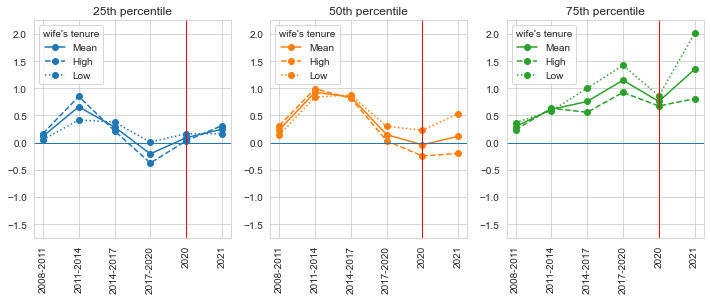

In [12]:
T = len(time_periods)
# time_periods_thin_labels= time_periods_thin
colors = sn.color_palette()

plt.figure(figsize=(12,4))
# plt.suptitle('Predicted time effect in quantile regressions, women 30-35 with kids, Spain',fontsize=14,y=1.05)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{}th percentile'.format(q),fontsize=12)
    plt.plot(np.arange(0,T*2,2),coeffs_period_m['Mean'][q],marker='o', label='Mean'.format(q),color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_m['p75'][q],marker='o', label='High'.format(q),color=colors[j],ls='--')
    plt.plot(np.arange(0,T*2,2),coeffs_period_m['p25'][q],marker='o', label='Low'.format(q),color=colors[j],ls=':')
#     plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
#     plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
#     for i in range(T):
#         plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),period_labels,rotation=90)
    plt.legend(title="wife's tenure")
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.75,2.25)

plt.savefig('./plots_tenure/qregs_spa_3035_time_intaction_men_kids.pdf',format='pdf',bbox_inches='tight')
plt.show()

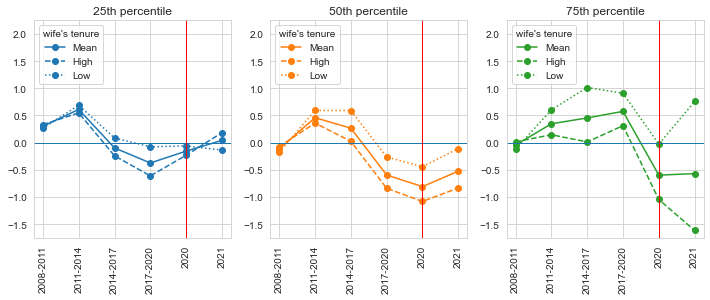

In [13]:
T = len(time_periods)
# time_periods_thin_labels= time_periods_thin
colors = sn.color_palette()

plt.figure(figsize=(12,4))
# plt.suptitle('Predicted time effect in quantile regressions, women 30-35 with kids, Spain',fontsize=14,y=1.05)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{}th percentile'.format(q),fontsize=12)
    plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k['Mean'][q],marker='o', label='Mean'.format(q),color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k['p75'][q],marker='o', label='High'.format(q),color=colors[j],ls='--')
    plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k['p25'][q],marker='o', label='Low'.format(q),color=colors[j],ls=':')
#     plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
#     plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
#     for i in range(T):
#         plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),period_labels,rotation=90)
    plt.legend(title="wife's tenure")
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.75,2.25)

plt.savefig('./plots_tenure/qregs_spa_3035_time_intaction_men_0k.pdf',format='pdf',bbox_inches='tight')
plt.show()

<a id='employment'></a>

# Employment

Jump to
 - [Women <45](#index)
 - [Women 20-25](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
 - [Women, extensive margin, 30-35](#women_ext_3035)
 - [Men, extensive margin, 30-35](#men_ext_3035)

In [59]:
emp_mothers_hemp = read_table(path+'logit_mothers_3035_hemp_yy.log',omit_list=['ccaa','act1','yd'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_mothers_hemp_0k = read_table(path+'logit_mothers_3035_hemp_yy_0k.log',omit_list=['ccaa','act1','yd'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)


header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_mothers_hemp.rename(columns=dict(zip(emp_mothers_hemp.keys(),header)),inplace=True)
emp_mothers_hemp_0k.rename(columns=dict(zip(emp_mothers_hemp_0k.keys(),header)),inplace=True)

coeffs_period_emp = {}
lower_95_period_emp = {}
upper_95_period_emp = {}
all_tabs_emp = dict(zip(['kids','no kids'],[emp_mothers_hemp,emp_mothers_hemp_0k]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_emp[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_emp[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_emp[kind]['upper_95'][period]))
    coeffs_period_emp[kind] = coeffs.copy()
    lower_95_period_emp[kind] = lower.copy()
    upper_95_period_emp[kind] = upper.copy()

In [79]:
emp_mothers_hnemp = read_table(path+'logit_mothers_3035_hnemp_yy.log',omit_list=['ccaa','act1','yd','52'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_mothers_hnemp_0k = read_table(path+'logit_mothers_3035_hnemp_yy_0k.log',omit_list=['ccaa','act1','yd','52'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)


header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_mothers_hnemp.rename(columns=dict(zip(emp_mothers_hnemp.keys(),header)),inplace=True)
emp_mothers_hnemp_0k.rename(columns=dict(zip(emp_mothers_hnemp_0k.keys(),header)),inplace=True)

coeffs_period_nemp = {}
lower_95_period_nemp = {}
upper_95_period_nemp = {}
all_tabs_nemp = dict(zip(['kids','no kids'],[emp_mothers_hnemp,emp_mothers_hnemp_0k]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_nemp[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_nemp[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_nemp[kind]['upper_95'][period]))
    coeffs_period_nemp[kind] = coeffs.copy()
    lower_95_period_nemp[kind] = lower.copy()
    upper_95_period_nemp[kind] = upper.copy()


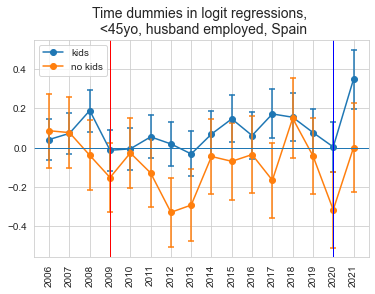

In [66]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(6,4))
plt.title('Time dummies in logit regressions, \n <45yo, husband employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp[kind][i],upper_95_period_emp[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(6,c='r',lw=1)
plt.axvline(T*2-4,c='b',lw=1)

plt.show()

In [63]:
emp_fathers_hemp = read_table(path+'logit_fathers_3035_hemp_yy.log',omit_list=['age2','ccaa','act1','ocup1','yd'],
                              end_row='_cons',keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_fathers_hemp_0k = read_table(path+'logit_fathers_3035_hemp_yy_0k.log',omit_list=['age2','ccaa','act1','ocup1','yd'],
                                 end_row='_cons',keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)


header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_fathers_hemp.rename(columns=dict(zip(emp_fathers_hemp.keys(),header)),inplace=True)
emp_fathers_hemp_0k.rename(columns=dict(zip(emp_fathers_hemp_0k.keys(),header)),inplace=True)
coeffs_period_emp_m = {}
lower_95_period_emp_m = {}
upper_95_period_emp_m = {}
all_tabs_emp_m = dict(zip(['kids','no kids'],[emp_fathers_hemp,emp_fathers_hemp_0k]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_emp_m[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_emp_m[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_emp_m[kind]['upper_95'][period]))
    coeffs_period_emp_m[kind] = coeffs.copy()
    lower_95_period_emp_m[kind] = lower.copy()
    upper_95_period_emp_m[kind] = upper.copy()


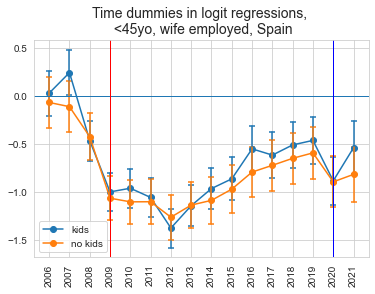

In [67]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(6,4))
plt.title('Time dummies in logit regressions, \n <45yo, wife employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp_m[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp_m[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp_m[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp_m[kind][i],upper_95_period_emp_m[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(6,c='r',lw=1)
plt.axvline(T*2-4,c='b',lw=1)

plt.show()

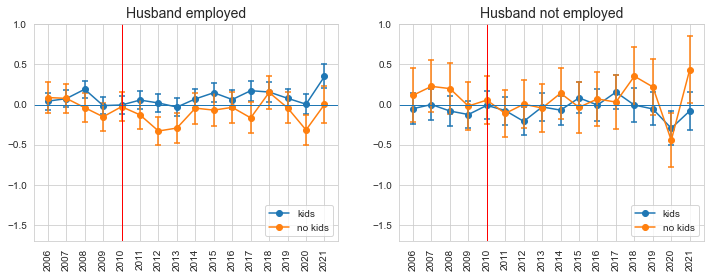

In [94]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.subplot(121)
# plt.title('Time dummies in logit regressions, \n 30-35, husband employed, Spain',fontsize=14)
plt.title('Husband employed',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp[kind][i],upper_95_period_emp[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.ylim(-1.7,1.0)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend(loc=4)
plt.axvline(8,c='r',lw=1)

plt.subplot(122)
# plt.title('Time dummies in logit regressions, \n 30-35, husband NOT employed, Spain',fontsize=14)
plt.title('Husband not employed',fontsize=14)

for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_nemp[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_nemp[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_nemp[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_nemp[kind][i],upper_95_period_nemp[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.ylim(-1.7,1.0)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend(loc=4)
plt.axvline(8,c='r',lw=1)

plt.savefig('./plots_tenure/logit_emp_spa_3035_women_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [68]:
emp_fathers_hnemp = read_table(path+'logit_fathers_3035_hnemp_yy.log',omit_list=['52','0','9','ccaa','act1','ocup1','yd'],end_row='_cons',
                              keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_fathers_hnemp_0k = read_table(path+'logit_fathers_3035_hnemp_yy_0k.log',omit_list=['52','0','9','age2','yd','ccaa','act1','ocup1'],end_row='_cons',
                              keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)



header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_fathers_hnemp.rename(columns=dict(zip(emp_fathers_hnemp.keys(),header)),inplace=True)
emp_fathers_hnemp_0k.rename(columns=dict(zip(emp_fathers_hnemp_0k.keys(),header)),inplace=True)
emp_fathers_hemp.rename(columns=dict(zip(emp_fathers_hemp.keys(),header)),inplace=True)
emp_fathers_hemp_0k.rename(columns=dict(zip(emp_fathers_hemp_0k.keys(),header)),inplace=True)
    
coeffs_period_nemp_m = {}
lower_95_period_nemp_m = {}
upper_95_period_nemp_m = {}
all_tabs_nemp_m = dict(zip(['kids','no kids'],[emp_fathers_hnemp,emp_fathers_hnemp_0k]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_nemp_m[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_nemp_m[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_nemp_m[kind]['upper_95'][period]))
    coeffs_period_nemp_m[kind] = coeffs.copy()
    lower_95_period_nemp_m[kind] = lower.copy()
    upper_95_period_nemp_m[kind] = upper.copy()


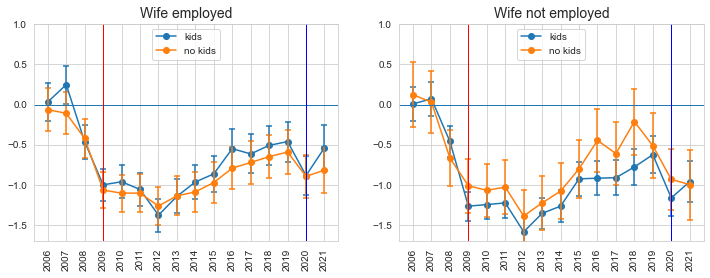

In [96]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.subplot(121)
# plt.title('Time dummies in logit regressions, \n 30-35, wife employed, Spain',fontsize=14)
plt.title('Wife employed',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp_m[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp_m[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp_m[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp_m[kind][i],upper_95_period_emp_m[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.ylim(-1.7,1.0)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(6,c='r',lw=1)
plt.axvline(T*2-4,c='b',lw=1)

plt.subplot(122)
# plt.title('Time dummies in logit regressions, \n 30-35, wife NOT employed, Spain',fontsize=14)
plt.title('Wife not employed',fontsize=14)

for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_nemp_m[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_nemp_m[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_nemp_m[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_nemp_m[kind][i],upper_95_period_nemp_m[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.ylim(-1.7,1.0)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(6,c='r',lw=1)
plt.axvline(T*2-4,c='b',lw=1)

plt.savefig('./plots_tenure/logit_emp_spa_3035_men_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()

<a id='women_ext_3035'></a>


# Quantile regressions for tenure, extensive margin: coefficients by year

### Women, 35-45

Jump to
 - [Women <45](#index)
 - [Women 30-35](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
 - [Employment regresssions](#employment)
 
 --------------
 Split result tables
 --------------
 Split result tables

In [137]:
path = './results/'

file_split('sqtreg_mothers_3035_ext.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'sqtreg_mothers_3035_ext_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_moms_45_50 = read_table(path+'sqtreg_mothers_3035_ext_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_moms_45_75 = read_table(path+'sqtreg_mothers_3035_ext_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)

file_split('sqtreg_mothers_0k_3035_ext.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'sqtreg_mothers_0k_3035_ext_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_moms_45_50_0k = read_table(path+'sqtreg_mothers_0k_3035_ext_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_moms_45_75_0k = read_table(path+'sqtreg_mothers_0k_3035_ext_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)

In [138]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
coeffs_period = {}
lower_95_period = {}
upper_95_period = {}
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs[q]['upper_95q{}'.format(q)][period]))
    coeffs_period[q] = coeffs.copy()
    lower_95_period[q] = lower.copy()
    upper_95_period[q] = upper.copy()


In [139]:
coeffs_period_0k = {}
lower_95_period_0k = {}
upper_95_period_0k = {}
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_0k[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_0k[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_0k[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_0k[q] = coeffs.copy()
    lower_95_period_0k[q] = lower.copy()
    upper_95_period_0k[q] = upper.copy()


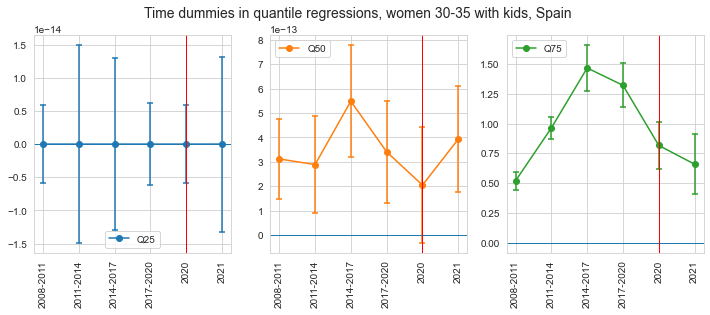

In [140]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35 with kids, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='Q{}'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

plt.show()

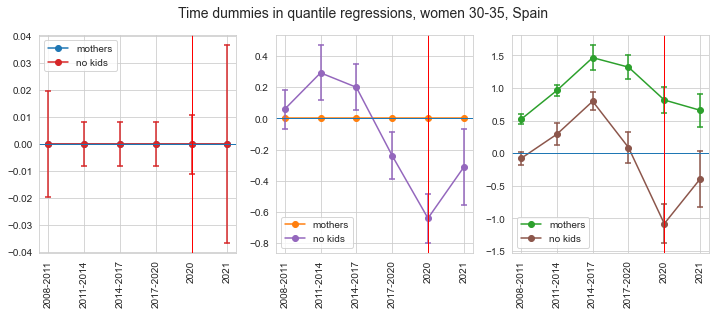

In [141]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='mothers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='no kids'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_0k[q][i],upper_95_period_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

plt.show()

<a id='men_ext_3035'></a>

### Men, 35-45

Jump to
 - [Women <45](#index)
 - [Women 30-35](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
 - [Employment regresssions](#employment)
 
 
 - [Women extensive margin, 30-35](#women_ext_3035)
 
 --------------
 Split result tables

In [142]:
path = './results/'

file_split('sqtreg_fathers_3035_ext.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25 = read_table(path+'sqtreg_fathers_3035_ext_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_dads_45_50 = read_table(path+'sqtreg_fathers_3035_ext_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_dads_45_75 = read_table(path+'sqtreg_fathers_3035_ext_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)

file_split('sqtreg_fathers_0k_3035_ext.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25_0k = read_table(path+'sqtreg_fathers_0k_3035_ext_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_dads_45_50_0k = read_table(path+'sqtreg_fathers_0k_3035_ext_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_dads_45_75_0k = read_table(path+'sqtreg_fathers_0k_3035_ext_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)

In [118]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
coeffs_period_m = {}
lower_95_period_m = {}
upper_95_period_m = {}
all_tabs_m = dict(zip([25,50,75],[tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_m[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_m[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_m[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_m[q] = coeffs.copy()
    lower_95_period_m[q] = lower.copy()
    upper_95_period_m[q] = upper.copy()


In [119]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
coeffs_period_m_0k = {}
lower_95_period_m_0k = {}
upper_95_period_m_0k = {}
all_tabs_m_0k = dict(zip([25,50,75],[tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_m_0k[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_m_0k[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_m_0k[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_m_0k[q] = coeffs.copy()
    lower_95_period_m_0k[q] = lower.copy()
    upper_95_period_m_0k[q] = upper.copy()


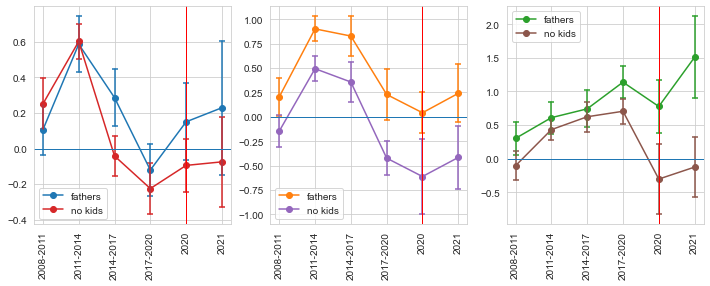

In [143]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period_m[q],marker='o', label='fathers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k[q],marker='o', label='no kids'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_m[q][i],upper_95_period_m[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_m_0k[q][i],upper_95_period_m_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

plt.show()